# Critical gradient analysis of some stellarators #

In [1]:
# Imports

import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import curve_fit

import desc.io
from desc.equilibrium.coords import get_rtz_grid
from desc.grid import LinearGrid

# from desc.compute.utils import dot
from desc.examples import get

### Loading equilibria ###

In [2]:
eq = get("HSX")

In [3]:
# Function to get value of a parameter directly
def get_value(eq, name, grid):
    return eq.compute(name, grid=grid)[name]


def get_arc_length(diff_l, grid):
    # Integrate differential length along field line with respect to zeta
    return cumulative_trapezoid(diff_l, x=grid.source_grid.nodes[:, 2], initial=0)


# Function to get the straight field line coordinate system
def get_field_line_grid(eq, rho=0.5, alpha=0, n_pol=4, n_points=200):
    # Get initial grid to get iota value
    initial_grid = get_rtz_grid(
        eq,
        np.array(np.sqrt(rho)),
        # np.array(rho),
        np.array(alpha),
        np.array(0),
        coordinates="raz",
        period=(np.inf, 2 * np.pi, np.inf),
    )
    iota = np.abs(get_value(eq, "iota", initial_grid)[1])
    NFP = eq.NFP
    n_tor = n_pol / (iota * NFP)
    good_grid = get_rtz_grid(
        eq,
        np.array(np.sqrt(rho)),
        # np.array(rho),
        np.array(alpha),
        # np.linspace(0,2*n_tor*np.pi,n_points*n_pol),
        np.linspace(0, 2 * n_tor * np.pi, n_points * n_pol),
        coordinates="raz",
        period=(np.inf, 2 * np.pi, np.inf),
    )
    return good_grid


def get_drift_curvature(eq, grid):
    cvdrift = get_value(eq, "cvdrift", grid=grid)
    a = get_value(eq, "a", grid=grid)
    B = get_value(eq, "|B|", grid=grid)
    drift_curvature = a**2 * np.multiply(cvdrift, B)
    # drift_curvature = cvdrift
    return drift_curvature, a


# Function for plotting the drift curvature
def plot_drift_curv(eq, grid, drift_curv=None, diff_l=None, l=None, a=None):

    # Compute all necessary quantities if not provided
    if drift_curv is None:
        drift_curv, a = get_drift_curvature(eq, grid)

    if l is not None:
        arc_length_vals = l
    else:
        if diff_l is None:
            diff_l = get_value(eq, "|e_zeta|r,a|", grid)
        arc_length_vals = get_arc_length(diff_l, grid)

    plt.figure()
    plt.plot(arc_length_vals, drift_curv)
    plt.xlabel("l")
    plt.ylabel(r"$K_D$ [1/Tm]")

In [4]:
# Quadratic fitting function for Kd peaks (bad curvature)
def Kd_quadratic(l, Reff_n, ln):
    lc = (l[0] + l[-1]) / 2
    return 1 / Reff_n * (1 - (l - lc) ** 2 / ln**2)


# Quadratic fiiting function for Kd valleys (good curvature)
def Kd_quadratic_(l, Reff_n, ln):
    lc = (l[0] + l[-1]) / 2
    return -1 / Reff_n * (1 - (l - lc) ** 2 / ln**2)


def fit_drift_peaks(l, Kd):
    peaks = []
    fits = []
    values = []

    val_0 = Kd[0]

    # Find indices where Kd changes sign (crosses zero)
    zero_crossings = np.where(np.diff(np.sign(Kd)))[0]

    # Initialize lists to store valid peak intervals
    peak_indices = []

    len_thres = 50
    # Loop over zero crossing pairs to check if it's a peak or a valley
    for i in range(0, len(zero_crossings) - 1):
        l_min_idx = zero_crossings[i]
        l_max_idx = zero_crossings[i + 1]
        len_peak = l_max_idx - l_min_idx

        # # Skip if there's insufficient data points
        if len_peak < len_thres:
            continue

        # Check the midpoint value of Kd
        mid_idx = (l_min_idx + l_max_idx) // 2
        if (
            Kd[mid_idx] * val_0 > 0
        ):  # Keep the range if it's abad curvature (same as initial)
            peak_indices.append((l_min_idx, l_max_idx))
        else:
            continue

        # Update threshold length depending on previous well
        # len_thres = int(0.6*len_peak)

    p0 = np.sign(val_0) * np.array([0.1, 1])
    # Loop through valid peak indices and perform fitting
    for l_min_idx, l_max_idx in peak_indices:
        # Extract the arc length and Kd values within the peak
        l_peak = l[l_min_idx : l_max_idx + 1]
        Kd_peak = Kd[l_min_idx : l_max_idx + 1]

        # Fit the quadratic curve to the peak
        popt, _ = curve_fit(Kd_quadratic, l_peak, Kd_peak, p0=p0)

        R_eff = np.abs(popt[0])
        L_par = l[l_max_idx] - l[l_min_idx]

        # Store the peak data and fitting parameters
        peaks.append((l_peak, Kd_peak))
        fits.append(popt)
        values.append([R_eff, L_par])
        p0 = popt  # TODO find better way of deinining initial guess

    data = {
        "peaks": peaks,
        "fits": fits,
        "values": values,
    }
    return data


def plot_drift_fits(l, drift_curv, data):

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(l, drift_curv, label=r"$-K_D$")

    num_fits = len(data["fits"])

    # Create a colormap
    colormap = plt.colormaps["viridis"]

    # Generate colors from the colormap
    colors = [colormap(i / num_fits) for i in range(num_fits)]

    for (l_peak, pos_Kd_peak), (R_eff, ln), (R_eff_abs, L_par), color in zip(
        data["peaks"], data["fits"], data["values"], colors
    ):
        plt.plot(
            l_peak,
            Kd_quadratic(l_peak, R_eff, ln),
            "--",
            label=f"Fit: $R_{{eff}}={R_eff_abs:.2f}$, $L_\\parallel={L_par:.2f}$",
            color=color,
            linewidth=1.5,
        )

    ax.set_xlabel(r"$l$", fontsize=14)
    ax.set_ylabel(r"$K_D$", fontsize=14)
    ax.set_title("Curvature Drift ($K_D$) and Quadratic Fits", fontsize=16)
    ax.grid = True
    # ax.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))  # Move the legend outside
    ax.legend(fontsize=12, loc="upper left")  # Move the legend outside

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

In [5]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w


def get_everything(eq, rho=0.5, alpha=0, n_pol=4, n_points=200, plot=True):

    # Create the grid
    grid = get_field_line_grid(eq, rho=rho, alpha=alpha, n_pol=n_pol, n_points=n_points)

    # Get all the necessary values
    drift_curv, a = get_drift_curvature(eq, grid)

    # drift_curvature = scipy.ndimage.gaussian_filter1d(drift_curv, sigma=40)
    # drift_curvature = moving_average(drift_curv, 5)
    drift_curvature = drift_curv

    # Multiply drift curvature by a^2 as in initial article
    diff_l = get_value(eq, "|e_zeta|r,a|", grid)

    # Integrate the differentail length
    l = get_arc_length(diff_l, grid)
    # zeta = grid.nodes[:,2]

    # Get peaks and fits
    data = fit_drift_peaks(l, drift_curvature)
    # data = fit_drift_peaks(zeta,drift_curvature)

    # Plot everything
    if plot:
        plot_drift_fits(l, drift_curvature, data)

    return (grid, drift_curvature, a, l, data)

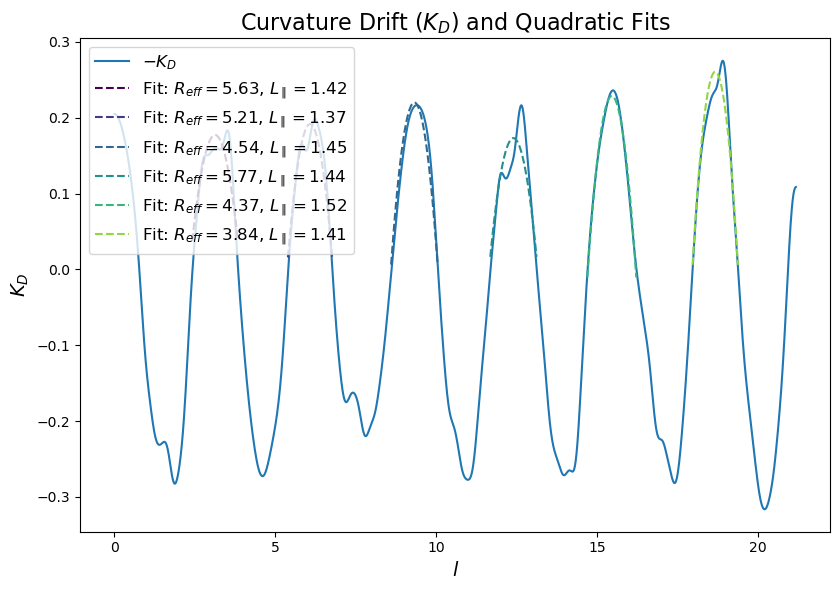

In [7]:
grid, drift_curvature, a, l, data = get_everything(eq, n_pol=10, plot=True);

In [8]:
def plot_coeffs(data_bad):
    values = data_bad["values"]
    R_eff = [row[0] for row in values]
    L_par = [row[1] for row in values]
    plt.figure()
    plt.plot(R_eff)
    plt.xlabel("Drift well number")
    plt.ylabel(r"$R_{eff}$")

    plt.figure()
    plt.plot(L_par)
    plt.xlabel("Drift well number")
    plt.ylabel(r"$L_{\parallel}$")

In [11]:
def calculate_critical_gradient(a, R_eff, L_par):
    return 2.66 * (a / R_eff + 8.00 * a / L_par)
    # return 2.66*(a/R_eff)


def get_critical_gradients(a, values, plot=True):
    critical_gradients = []
    for R_eff, L_par in values:
        critical_gradients.append(calculate_critical_gradient(a, R_eff, L_par))
    if plot:
        plt.figure()
        plt.plot(critical_gradients)
        plt.ylabel(r"$a/L_T$")
        plt.title(f"Critical gradients")

        # Find the minimum value and its index
        min_value = np.min(critical_gradients)
        min_index = np.argmin(critical_gradients)

        # Annotate the minimum value on the plot
        plt.annotate(
            f"Min: {min_value:.2f}",
            xy=(min_index, min_value),
            # xytext=(min_index + 1,0.5),  # Adjust text position
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

        plt.show

    return critical_gradients

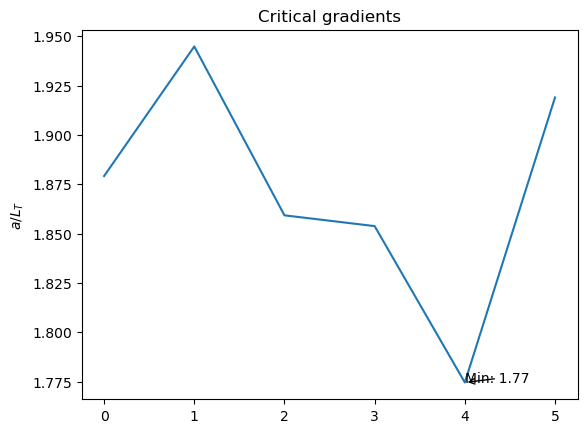

In [12]:
get_critical_gradients(a, data["values"]);

In [13]:
def fit_all_drift_peaks(l, Kd):

    # Save all values for bad curvature
    peaks_bad = []
    fits_bad = []
    values_bad = []

    # Save all values for good curvature
    peaks_good = []
    fits_good = []
    values_good = []

    # Make sure we have bad curvature at 0
    val_0 = Kd[0]

    # Find indices where Kd changes sign (crosses zero)
    zero_crossings = np.where(np.diff(np.sign(Kd)))[0]

    # Initialize lists to store valid peak intervals
    bad_peak_indices = []
    good_peak_indices = []

    len_thres = 60
    # Loop over zero crossing pairs to check if it's a peak or a valley
    for i in range(0, len(zero_crossings) - 1):
        l_min_idx = zero_crossings[i]
        l_max_idx = zero_crossings[i + 1]
        len_peak = l_max_idx - l_min_idx

        # # Skip if there's insufficient data points
        if len_peak < len_thres:
            continue

        # Check the midpoint value of Kd
        mid_idx = (l_min_idx + l_max_idx) // 2
        if Kd[mid_idx] * val_0 > 0:  # Keep the range if it's a peak (Kd is positive)
            bad_peak_indices.append((l_min_idx, l_max_idx))
        else:
            good_peak_indices.append((l_min_idx, l_max_idx))

        len_thres = int(0.3 * len_peak)

    def get_fits(peak_indices, bad_curv=True):
        # Define variables for storing the data
        peaks = []
        fits = []
        values = []

        p0 = np.sign(val_0) * np.array([0.1, 1])
        # Loop through valid peak indices and perform fitting
        for l_min_idx, l_max_idx in peak_indices:
            # Extract the arc length and Kd values within the peak
            l_peak = l[l_min_idx : l_max_idx + 1]
            Kd_peak = Kd[l_min_idx : l_max_idx + 1]

            # Fit the quadratic curve to the peak
            if bad_curv:
                popt, _ = curve_fit(Kd_quadratic, l_peak, Kd_peak, p0)
            else:
                popt, _ = curve_fit(Kd_quadratic, l_peak, Kd_peak, -p0)

            R_eff = np.abs(popt[0])
            L_par = l[l_max_idx] - l[l_min_idx]
            peaks.append((l_peak, Kd_peak))
            fits.append(popt)
            values.append([R_eff, L_par])
        return peaks, fits, values

    peaks_bad, fits_bad, values_bad = get_fits(bad_peak_indices, bad_curv=True)
    peaks_good, fits_good, values_good = get_fits(good_peak_indices, bad_curv=False)
    data_bad = {"extrema": peaks_bad, "fits": fits_bad, "values": values_bad}
    data_good = {"extrema": peaks_good, "fits": fits_good, "values": values_good}

    return data_bad, data_good

In [14]:
# def plot_all_drift_fits(l,drift_curv,bad_peaks,bad_fits,bad_values,good_peaks,good_fits,good_values):
def plot_all_drift_fits(l, drift_curv, data_bad, data_good):

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(l, drift_curv, label=r"$-K_D$")

    for (l_peak, _), (Reff_n, ln), (R_eff_abs, L_par) in zip(
        data_bad["extrema"], data_bad["fits"], data_bad["values"]
    ):
        plt.plot(
            l_peak,
            Kd_quadratic(l_peak, Reff_n, ln),
            "--",
            label=f"Fit: $R_{{eff}}={R_eff_abs:.2f}$, $L_\\parallel={L_par:.2f}$",
            linewidth=1.5,
        )

    for (l_peak, _), (Reff_n, ln), (R_eff_abs, L_par) in zip(
        data_good["extrema"], data_good["fits"], data_good["values"]
    ):
        plt.plot(
            l_peak,
            Kd_quadratic(l_peak, Reff_n, ln),
            "--",
            label=f"Fit: $R_{{good}}={R_eff_abs:.2f}$, $L_w={L_par:.2f}$",
            linewidth=1.5,
        )

    ax.set_xlabel(r"$l$", fontsize=14)
    ax.set_ylabel(r"$K_D$ [1/Tm]", fontsize=14)
    ax.set_title("Curvature Drift ($K_D$) and Quadratic Fits", fontsize=16)
    ax.grid = True
    ax.legend(
        fontsize=12, loc="center left", bbox_to_anchor=(1, 0.5)
    )  # Move the legend outside

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

In [15]:
def get_all_everything(eq, rho=0.5, alpha=0, n_pol=4, n_points=200, plot=False):

    # Create the grid
    grid = get_field_line_grid(eq, rho=rho, alpha=alpha, n_pol=n_pol, n_points=n_points)

    # Get all the necessary values
    drift_curv, a = get_drift_curvature(eq, grid)

    # drift_curv = scipy.ndimage.gaussian_filter1d(drift_curv, sigma=15)

    diff_l = get_value(eq, "|e_zeta|r,a|", grid)

    # Integrate the differentail length
    l = get_arc_length(diff_l, grid)

    # Get peaks and fits
    data_bad, data_good = fit_all_drift_peaks(l, drift_curv)

    # Plot everything
    if plot:
        plot_all_drift_fits(l, drift_curv, data_bad, data_good)

    return (grid, drift_curv, a, l, data_bad, data_good)

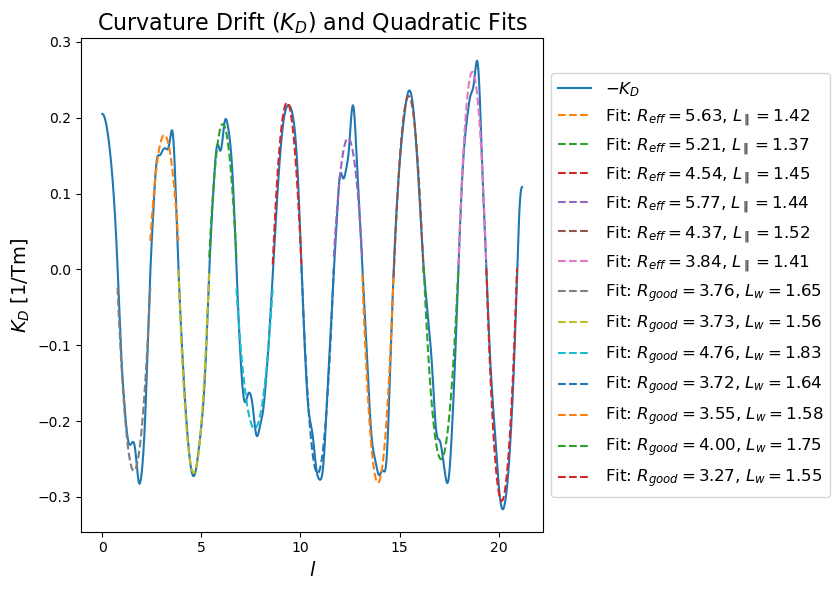

In [17]:
grid, drift_curv, a, l, data_bad, data_good = get_all_everything(
    eq, n_pol=10, plot=True
);

In [18]:
def calculate_Ls(eq, grid):
    shear = get_value(eq, "shear", grid)[1]
    q = get_value(eq, "q", grid)[1]
    R = get_value(eq, "R0", grid)
    return np.abs(q * R / shear)


def Theta_function(x):
    # Define Heaviside step function
    return x * np.where(x >= 0, 1, 0)


def check_peaks(peaks_bad, peaks_good):
    # Function that checks if first extremum is a peak (bad curvature)
    # or valley (good curvature) in the curvature drift
    l_bad = peaks_bad[0][0][0]
    l_good = peaks_good[0][0][0]
    if l_bad < l_good:
        first = "bad"
    else:
        first = "good"
    return first


def zero_div(x):
    if x == 0:
        result = np.inf
    else:
        result = 1 / x
    return result

In [19]:
def get_parallel_correlation_lengths(values_bad, values_good, L_s, first, type="next"):
    # Example values (replace with your actual calculated values)
    L_parallel_inv = []
    total_peaks = len(values_bad) + len(values_good)

    # If we want to give a random start
    if total_peaks % 2 == 1:
        if first == "bad" and type == "next":
            values_good = values_good[:-1]
        elif first == "bad" and type == "previous":
            values_bad = values_bad[1:]
        elif first == "good" and type == "next":
            values_good = values_good[1:]
        elif first == "good" and type == "previous":
            values_bad = values_bad[:-1]
    else:
        if first == "bad" and type == "previous":
            values_bad = values_bad[1:]
            values_good = values_good[:-1]
        elif first == "good" and type == "next":
            values_good = values_good[1:]
            values_bad = values_bad[:-1]

    for (R_eff, _), (R_good, L_w) in zip(values_bad, values_good):

        # Calculate p1 and p2
        p1 = R_eff / L_w - 0.20
        p2 = R_eff / L_s - 0.15

        # Calculate 1/L_parallel
        L_par_inv = (
            (1 / R_eff)
            * Theta_function(p1)
            * (Theta_function(R_eff / R_good - 1) / (R_eff / R_good + 1))
            * 0.5
            * (1 + np.tanh(20 * p2))
        )
        L_parallel_inv.append(L_par_inv)
    return L_parallel_inv

In [20]:
L_s = calculate_Ls(eq, grid)
L_s

23.506128205950773

In [21]:
first = check_peaks(data_bad["extrema"], data_good["extrema"])
first

'good'

In [22]:
def zero_div(x):
    if x == 0:
        result = np.inf
    else:
        result = 1 / x
    return result

[0.12039329276405936, 0.021590548849512326, 0.047892147236871414, 0.13927989772042715, 0.019106435600435897, 0.029414343936083304]


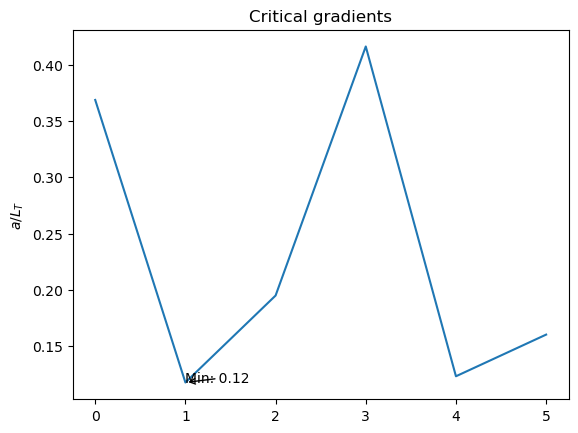

In [31]:
L_par_inv = get_parallel_correlation_lengths(
    data_bad["values"], data_good["values"], L_s, "good", type="next"
)
print(L_par_inv)
L_par = [zero_div(x) for x in L_par_inv]
R_eff = [row[0] for row in data_bad["values"]]
# print(R_eff)
values = zip(R_eff, L_par)
get_critical_gradients(a, values);

[5.634641734447069, 5.213711446349169, 4.541729326441421, 5.771771288908073, 4.371938735392086, 3.835423418433931]
[Array(1.87917633, dtype=float64), Array(1.94481642, dtype=float64), Array(1.85927004, dtype=float64), Array(1.85380679, dtype=float64), Array(1.77458645, dtype=float64), Array(1.91897919, dtype=float64)]


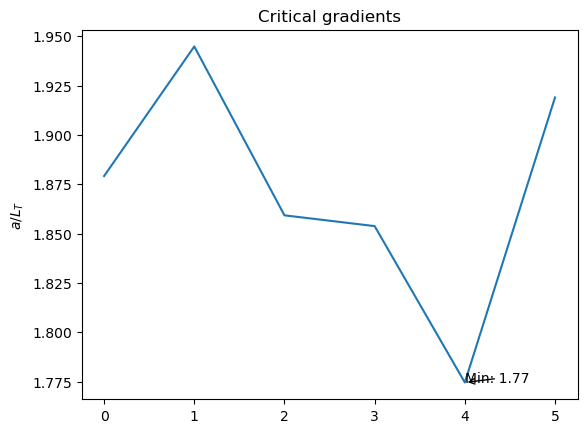

In [32]:
R_eff = [row[0] for row in data_bad["values"]]
print(R_eff)
L_par = [row[1] for row in data_bad["values"]]
crit2 = get_critical_gradients(a, zip(R_eff, L_par))
print(crit2)